Data set paris

In [1]:
import pandas as pd
import requests
import os

WINNING_DATE = "2024-06-10"

PAS BESOIN DE RELANCER CETTE CELLULE

In [ ]:
import os
import requests
import pandas as pd

WINNING_DATE = "2024-06-10"
DATA_URL = f"http://data.insideairbnb.com/france/ile-de-france/paris/{WINNING_DATE}/data/listings.csv.gz"

SAVE_PATH = f"../data/paris_listings_ready_{WINNING_DATE}.csv.gz"

folder_path = os.path.dirname(SAVE_PATH)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Dossier créé : {folder_path}")

print(f"Téléchargement de la version {WINNING_DATE}")

# 1. TÉLÉCHARGEMENT
if not os.path.exists(SAVE_PATH):
    print(f"Depuis : {DATA_URL}")
    print(f"Vers : {SAVE_PATH}")
    try:
        response = requests.get(DATA_URL, stream=True)
        if response.status_code == 200:
            with open(SAVE_PATH, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024*1024):
                    f.write(chunk)
            print("Téléchargement terminé")
        else:
            print(f"Erreur de téléchargement (code {response.status_code})")
    except Exception as e:
        print(f"Erreur : {e}")
else:
    print(f"Fichier déjà présent : {SAVE_PATH}")

# 2. CHARGEMENT ET NETTOYAGE PRÉLIMINAIRE
print("\nPréparation du dataset")
try:
    df = pd.read_csv(SAVE_PATH, compression='gzip')
    print(f"Taille brute : {len(df)} lignes")

    if df['price'].dtype == 'object':
        df['price_clean'] = df['price'].astype(str).str.replace(r'[$,]', '', regex=True)
        df['price_clean'] = pd.to_numeric(df['price_clean'], errors='coerce')
    else:
        df['price_clean'] = df['price']

    df_clean = df
    df_clean = df_clean.dropna(subset=['price_clean'])

    print(f"Taille après suppression des sans-prix : {len(df_clean)} lignes")
    perte = 100 - (len(df_clean)/len(df)*100)
    print(f"Perte de données : {perte:.1f}%")

    sample_amenity = str(df_clean['amenities'].iloc[0])
    print(f"\nExemple d'amenities : {sample_amenity[:50]}...")

    if "wifi" in sample_amenity.lower() or "[" in sample_amenity:
        print("Amenities ok")

        clean_save_path = f"../data/paris_listings_ready_{WINNING_DATE}.csv.gz"
        df_clean.to_csv(clean_save_path, index=False, compression='gzip')
        print(f"Sauvegardé : {clean_save_path}")
    else:
        print("Attention : les amenities semblent vides")

except FileNotFoundError:
    print(f"Fichier introuvable : {SAVE_PATH}")


--- TÉLÉCHARGEMENT DE LA VERSION GAGNANTE (2024-06-10) ---
ℹ️ Le fichier existe déjà ici : ../data/paris_listings_ready_2024-06-10.csv.gz

--- PRÉPARATION DU DATASET ---
Taille brute : 74579 lignes
Taille après suppression des sans-prix : 74579 lignes
Perte de données : 0.0% (Acceptable)

Exemple d'amenities : ["Smart lock", "Smoke alarm", "Cooking basics", "H...
✅ AMENITIES CONFIRMÉES : Prêt pour le Feature Engineering !
💾 Fichier de travail sauvegardé sous : '../data/paris_listings_ready_2024-06-10.csv.gz'


Audit of dataset + feature selection for the model


2. Chargement du fichier : ../data/paris_listings_ready_2024-06-10.csv.gz...
   -> 34 colonnes supprimées (Liées au Host ou Scrapping).
   -> Reste : 42 colonnes axées sur le LOGEMENT.

3. Génération de l'audit de complétude...


/var/folders/cg/t4c1vydn6vx83tr4gybx2_980000gn/T/ipykernel_5273/2706663846.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Taux_Presence', y='Variable', data=presence_df, palette=colors)


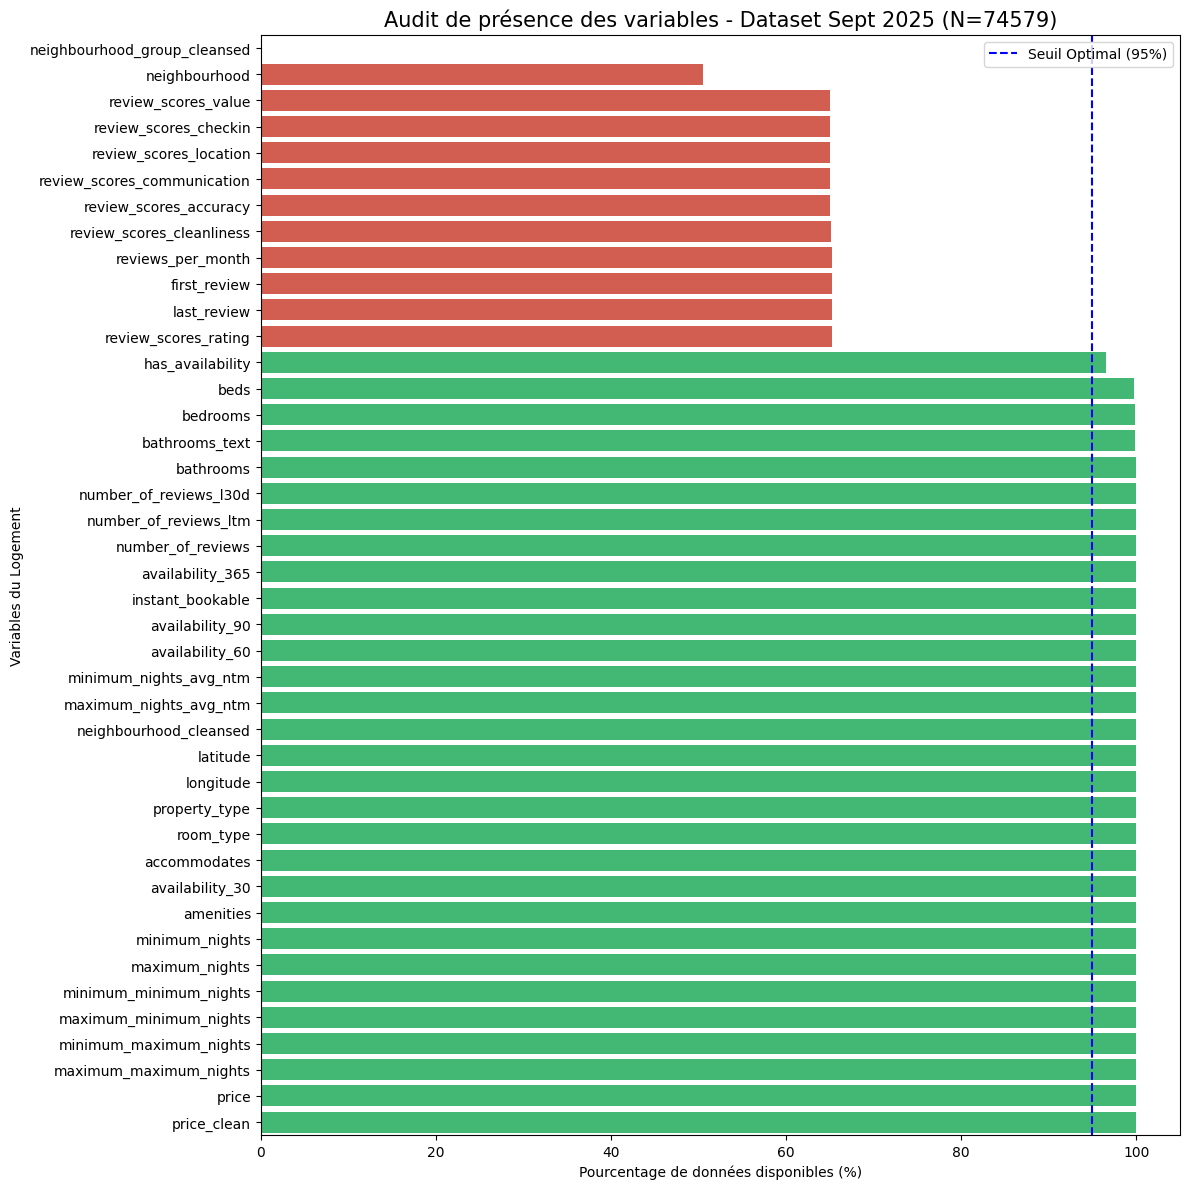


--- ⚠️ VARIABLES VIDES (0% de données) ---
['neighbourhood_group_cleansed']

--- CHECK CRITIQUE : AMENITIES ---
✅ AMENITIES : 100.00% (C'est bon !)


In [ ]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

RAW_FILE_PATH = f"../data/paris_listings_ready_{WINNING_DATE}.csv.gz"

folder_path = os.path.dirname(RAW_FILE_PATH)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Dossier créé : {folder_path}")

if not os.path.exists(RAW_FILE_PATH):
    print(f"Fichier introuvable : {RAW_FILE_PATH}")
    print("Lancer d'abord le script de téléchargement")
else:
    # ==============================================================================
    # 2. CHARGEMENT & FILTRAGE (Scraping & Host)
    # ==============================================================================
    print(f"\nChargement : {RAW_FILE_PATH}")
    df = pd.read_csv(RAW_FILE_PATH)

    scraping_cols = [
        'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 
        'description', 'neighborhood_overview', 'picture_url', 'calendar_updated', 
        'calendar_last_scraped', 'license'
    ]

    host_cols = [c for c in df.columns if c.startswith('host_') or c.startswith('calculated_host_')]

    cols_to_drop = scraping_cols + host_cols

    existing_drops = [c for c in cols_to_drop if c in df.columns]
    df_audit = df.drop(columns=existing_drops)

    print(f"   {len(existing_drops)} colonnes supprimées (host/scraping)")
    print(f"   Reste : {df_audit.shape[1]} colonnes")

    # ==============================================================================
    # 3. AUDIT VISUEL (Barplot)
    # ==============================================================================
    print("\nAudit de complétude")

    presence = df_audit.notnull().mean() * 100
    presence_df = presence.reset_index()
    presence_df.columns = ['Variable', 'Taux_Presence']
    presence_df = presence_df.sort_values(by='Taux_Presence', ascending=True)

    plt.figure(figsize=(12, 12))
    colors = ['#e74c3c' if x < 90 else '#2ecc71' for x in presence_df['Taux_Presence']]

    sns.barplot(x='Taux_Presence', y='Variable', data=presence_df, palette=colors)

    plt.axvline(x=95, color='blue', linestyle='--', label='Seuil optimal (95%)')
    plt.title(f'Présence des variables - Paris {WINNING_DATE} (N={len(df)})', fontsize=15)
    plt.xlabel('Pourcentage de données disponibles (%)')
    plt.ylabel('Variables')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nVariables vides (0%)")
    empty_cols = presence_df[presence_df['Taux_Presence'] == 0]['Variable'].tolist()
    print(empty_cols if empty_cols else "Aucune")

    print("\nCheck amenities")
    amenities_score = presence_df[presence_df['Variable'] == 'amenities']['Taux_Presence'].values
    if len(amenities_score) > 0 and amenities_score[0] > 99:
         print(f"Amenities : {amenities_score[0]:.2f}%")
    else:
         print(f"Amenities : {amenities_score}% - problème")


Verification of presence of amenities and prices in the dataset


--- Distribution du Prix (74579 lignes) ---
count       74579
unique       1598
top       $150.00
freq         2176
Name: price_clean, dtype: object


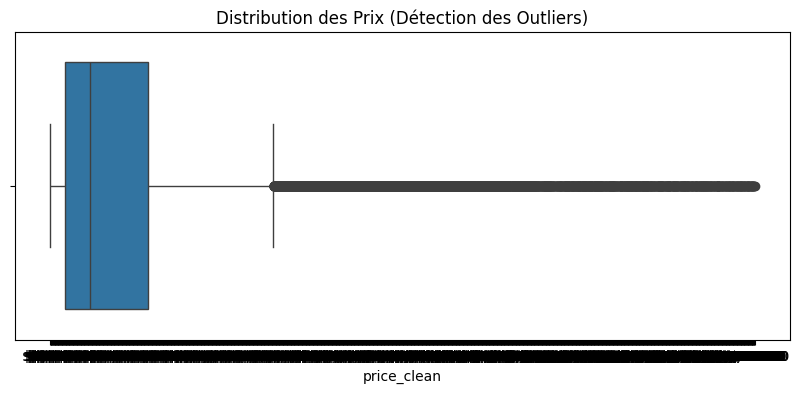


--- Structure des Amenities (Exemple Ligne 0) ---
Type : <class 'str'>
Contenu : ["Smart lock", "Smoke alarm", "Cooking basics", "Hangers", "Wifi", "Dishes and silverware", "Hair dryer", "Children\u2019s books and toys", "Kitchen",...
Parsing Test : OK (15 équipements détectés)


In [ ]:
# A. Prix
print(f"\nDistribution du prix ({len(df)} lignes)")
print(df['price_clean'].describe())

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['price_clean'])
plt.title("Distribution des prix")
plt.show()

# B. Amenities
print("\nStructure des amenities (exemple ligne 0)")
amenity_sample = df['amenities'].iloc[0]
print(f"Type : {type(amenity_sample)}")
print(f"Contenu : {str(amenity_sample)[:150]}...")

import json
try:
    test_parse = json.loads(amenity_sample.replace("'", '"')) if isinstance(amenity_sample, str) else amenity_sample
    print(f"Parsing ok ({len(test_parse)} équipements)")
except:
    print("Parsing : format complexe, nettoyage à prévoir")


Encoding amneties, d'abbord audit

=== AMENITIES AVEC COUNT > 1000 ===
                                                    count
Kitchen                                             69676
Wifi                                                66596
Smoke alarm                                         57304
Hot water                                           56073
Essentials                                          53450
Hair dryer                                          52177
Dishes and silverware                               51611
Bed linens                                          50821
Cooking basics                                      50625
Iron                                                48111
Refrigerator                                        47818
Hangers                                             46897
Washer                                              46746
Microwave                                           41038
TV                                                  40045
Heating                             

<Axes: title={'center': 'Top 30 Amenities à Paris'}>

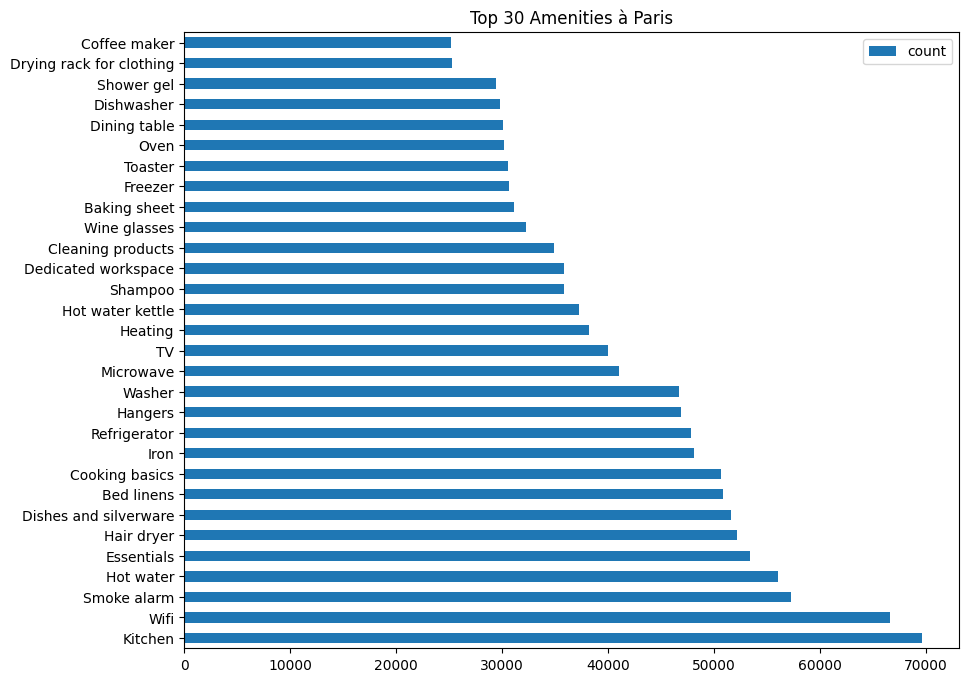

In [ ]:
from collections import Counter
import json

def get_amenities_list(x):
    try:
        return json.loads(x.replace("'", '"')) if isinstance(x, str) else x
    except Exception as e:
        return []

all_amenities = []
df['amenities'].apply(get_amenities_list).apply(all_amenities.extend)

amenity_counts = Counter(all_amenities)
amenity_freq = pd.DataFrame.from_dict(amenity_counts, orient='index', columns=['count'])
amenity_freq = amenity_freq.sort_values(by='count', ascending=False)

print("Amenities avec count > 1000")
with pd.option_context('display.max_rows', None):
    print(amenity_freq[amenity_freq['count'] > 1000])

amenity_freq.head(30).plot(kind='barh', figsize=(10, 8), title="Top 30 amenities - Paris")


Création df sans les colonnes inutiles pour le modèle modulable pour d'autres villes

In [ ]:
import pandas as pd
import numpy as np
import re
import os

# ==============================================================================
# FONCTION UNIQUE ET DÉFINITIVE (VERSION RICHE : BEDS/BATHS/REVIEWS)
# ==============================================================================
def process_paris_from_scratch(file_path):
    print(f"Chargement : {file_path}")
    
    # 1. Chargement (Optimisé RAM)
    df = pd.read_csv(file_path, compression='gzip', low_memory=False)
    print(f"   Input shape : {df.shape}")

    # 2. Nettoyage PRIX
    if 'price' in df.columns:
        df['price_clean'] = df['price'].astype(str).str.replace(r'[$,€£]', '', regex=True)
        df['price_clean'] = df['price_clean'].str.replace(',', '')
        df['price_clean'] = pd.to_numeric(df['price_clean'], errors='coerce')
    else:
        raise KeyError("Colonne 'price' introuvable")

    df = df.dropna(subset=['price_clean'])
    if len(df) == 0: raise ValueError("Nettoyage du prix a tout supprimé")
        
    # Filtre Outliers
    q1, q99 = df['price_clean'].quantile([0.01, 0.99])
    df = df[(df['price_clean'] >= q1) & (df['price_clean'] <= q99)]
    print(f"   Prix valides : {len(df)} listings")

    # 3. Géographie
    lat_center, lon_center = 48.8566, 2.3522
    df['dist_raw'] = np.sqrt((df['latitude'] - lat_center)**2 + (df['longitude'] - lon_center)**2)
    city_radius = df['dist_raw'].quantile(0.95)
    df['dist_to_center'] = np.clip(df['dist_raw'] / city_radius, 0, 1)
    
    # 4. Extraction Bathrooms
    if 'bathrooms_text' in df.columns:
        def clean_bath(text):
            if pd.isna(text): return 1.0
            text = str(text).lower()
            if 'half' in text: return 0.5
            res = re.findall(r"(\d+(\.\d+)?)", text)
            return float(res[0][0]) if res else 1.0
        df['bathrooms_qty'] = df['bathrooms_text'].apply(clean_bath)
    else:
        df['bathrooms_qty'] = 1.0

    # 5. Amenities (Hybride)
    if 'amenities' in df.columns:
        df['amen_str'] = df['amenities'].astype(str).str.lower()
        
        # Power Items
        power_map = {
            'has_ac': 'air conditioning|clim',
            'has_elevator': 'elevator|lift|ascenseur',
            'has_dishwasher': 'dishwasher|lave-vaisselle',
            'has_parking': 'parking',
            'has_balcony': 'balcony|terrace|patio|balcon|terrasse',
            'has_washing_machine': 'washer|lave-linge'
        }
        for col, regex in power_map.items():
            df[col] = df['amen_str'].str.contains(regex, regex=True).astype(int)
            
        # Standing Thermique
        def get_thermal(text):
            if 'air conditioning' in text or 'clim' in text: return 2
            if 'fan' in text or 'ventilateur' in text: return 1
            return 0
        df['standing_thermal'] = df['amen_str'].apply(get_thermal)

        # Scores
        themes = {
            'score_chef_kitchen': ['stove', 'oven', 'refrigerator', 'freezer', 'wine glasses'],
            'score_coffee': ['coffee maker', 'espresso', 'nespresso'],
            'score_wellness': ['pool', 'sauna', 'jacuzzi', 'bathtub'],
            'score_work': ['wifi', 'dedicated workspace', 'monitor'],
            'score_view': ['view', 'skyline', 'waterfront'],
            'score_secure': ['lockbox', 'self check-in']
        }
        for score_name, keywords in themes.items():
            df[score_name] = df['amen_str'].apply(lambda x: sum(1 for k in keywords if k in x))

    # 6. Quartier
    if 'neighbourhood_cleansed' in df.columns:
        freq = df['neighbourhood_cleansed'].value_counts(normalize=True)
        df['neigh_popularity'] = df['neighbourhood_cleansed'].map(freq).fillna(0)

    # 7. Encodage
    if 'property_type' in df.columns:
        def group_prop(x):
            x = str(x).lower()
            if 'entire' in x or 'apt' in x: return 'entire_unit'
            if 'private' in x: return 'private_room'
            if 'hotel' in x: return 'hotel'
            return 'other'
        df['prop_group'] = df['property_type'].apply(group_prop)
        df = pd.get_dummies(df, columns=['prop_group'], prefix='pg', drop_first=False)

    if 'room_type' in df.columns:
        df = pd.get_dummies(df, columns=['room_type'], prefix='rt', drop_first=False)

    # 8. Nettoyage Final
    df['city_label'] = 'Paris'
    df['target_class'] = pd.qcut(df['price_clean'], q=4, labels=[0, 1, 2, 3]).astype(int)

    cols_to_drop = [
        'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 
        'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 
        'host_since', 'host_location', 'host_about', 'host_response_time', 
        'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
        'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 
        'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 
        'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 
        'longitude', 'property_type', 'room_type', 'bathrooms', 'bathrooms_text',
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 
        'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
        'maximum_maximum_nights', 'maximum_nights_avg_ntm', 
        'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 
        'availability_90', 'availability_365', 'calendar_last_scraped', 
        'number_of_reviews_ltm', 'number_of_reviews_l30d',
        'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_location', 'review_scores_value', 'license', 'instant_bookable', 
        'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
        'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 
        'reviews_per_month', 'amen_str', 'dist_raw', 'pg_other', 'rt_Hotel room'
    ]
    
    df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)
    
    # Imputation (beds, bedrooms, bathrooms_qty)
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    print(f"Shape finale : {df.shape}")
    return df


# ==============================================================================
# EXÉCUTION
# ==============================================================================
RAW_FILE_PATH = f"../data/paris_listings_ready_{WINNING_DATE}.csv.gz"

df_paris_final = process_paris_from_scratch(RAW_FILE_PATH)

print("\nColonnes disponibles :")
print(df_paris_final.columns.tolist())

# Sauvegarde
df_paris_final.to_csv('../data/paris_dataset_final_ready.csv.gz', index=False, compression='gzip')


🔄 Chargement depuis : ../data/paris_listings_ready_2024-06-10.csv.gz
   Input shape : (74579, 76)
   💰 Prix valides : 73111 listings
✅ Terminé ! Shape finale : (73111, 30)

🚀 Colonnes disponibles :
['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']


In [ ]:
print(f"Shape : {df_paris_final.shape}")

pd.set_option('display.max_columns', None)
print(df_paris_final.head())


Dataset final prêt : (73111, 30)
   accommodates  bedrooms  beds  minimum_nights_avg_ntm  number_of_reviews  \
0             2       1.0   0.0                     2.0                  4   
1             1       1.0   1.0                    30.0                 42   
2             2       0.0   1.0                     1.0                403   
3             4       2.0   1.0                    10.0                354   
4             1       1.0   1.0                     4.0                278   

   price_clean  dist_to_center  bathrooms_qty  has_ac  has_elevator  \
0        250.0        0.577017            1.0       0             0   
1         60.0        0.252107            1.5       0             0   
2         96.0        0.102716            1.0       0             0   
3        160.0        0.036952            1.0       0             0   
4         48.0        0.469133            1.0       1             1   

   has_dishwasher  has_parking  has_balcony  has_washing_machine  \
0  

A ne pas relancer, c'est pour justifier la supression de certaines colonnes dans le dataset final (meme si la plupart des variables non utilises ne sont pas detaille ici)

=== 1. AUDIT TECHNIQUE (Valeurs manquantes & Types) ===
✅ Aucun NaN détecté. Dataset 100% rempli.

Types de colonnes :
int64      16
float64     7
bool        6
str         1
Name: count, dtype: int64

=== 2. AUDIT DE L'ÉQUILIBRE (Target) ===
target_class
0    0.261438
1    0.238664
2    0.250291
3    0.249607
Name: proportion, dtype: float64
✅ Classes bien équilibrées (Effet Quartiles).

=== 3. AUDIT DU SIGNAL (Corrélations) ===
Top 10 Corrélations Positives (Ce qui fait monter le prix) :
price_clean         1.000000
target_class        0.681494
bedrooms            0.465915
accommodates        0.465111
bathrooms_qty       0.409981
beds                0.310000
has_dishwasher      0.186338
has_ac              0.175888
score_wellness      0.171071
standing_thermal    0.155358
Name: price_clean, dtype: float64

Top 5 Corrélations Négatives (Ce qui fait baisser le prix) :
score_view                0.032500
minimum_nights_avg_ntm   -0.064034
number_of_reviews        -0.080754
neigh_populari

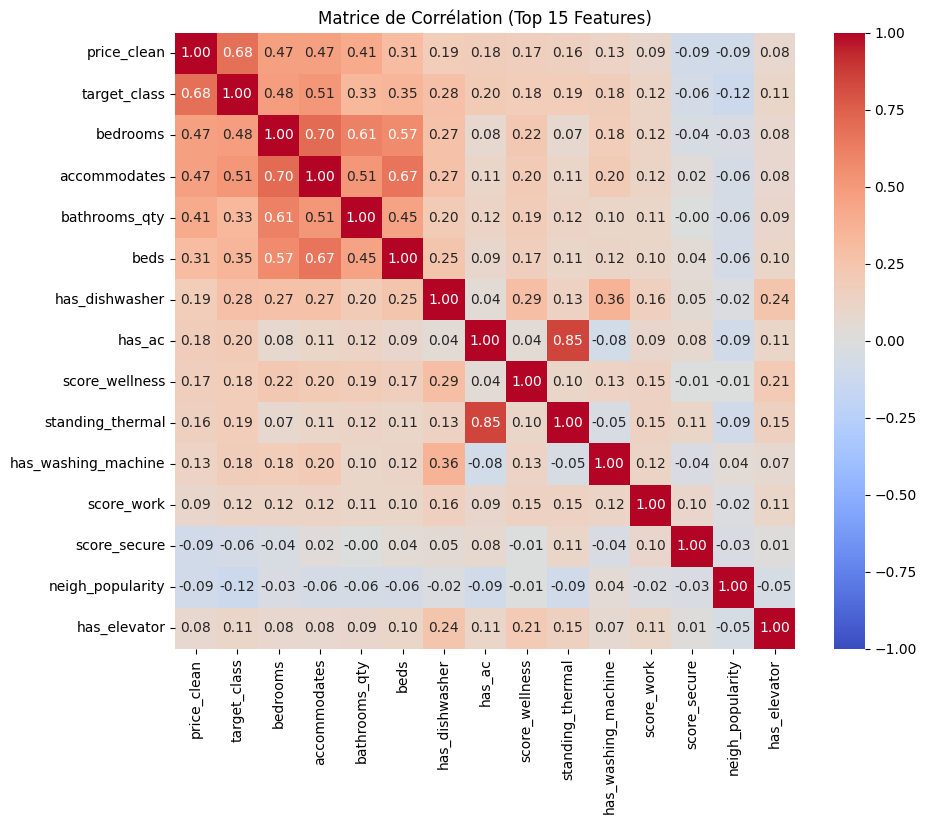


=== 4. DÉTECTION DES 'VARIANCES NULLES' (Colonnes inutiles) ===
⚠️ Colonnes quasi-constantes (>99%) détectées : [('rt_Shared room', np.float64(0.9976610906703506)), ('city_label', np.float64(1.0))]
Conseil : Vous pouvez les supprimer, elles n'apportent presque aucune info.


In [ ]:
df = df_paris_final

print("1. Valeurs manquantes et types")
null_counts = df.isnull().sum()
if null_counts.sum() == 0:
    print("Aucun NaN")
else:
    print("Il reste des NaNs :")
    print(null_counts[null_counts > 0])

print("\nTypes de colonnes :")
print(df.dtypes.value_counts())

print("\n2. Equilibre des classes")
target_dist = df['target_class'].value_counts(normalize=True).sort_index()
print(target_dist)
if target_dist.max() < 0.30 and target_dist.min() > 0.20:
    print("Classes équilibrées")
else:
    print("Classes déséquilibrées")

print("\n3. Corrélations")
corr_matrix = df.select_dtypes(include=[np.number]).corr()
price_corr = corr_matrix['price_clean'].sort_values(ascending=False)

print("Top 10 corrélations positives :")
print(price_corr.head(10))

print("\nTop 5 corrélations négatives :")
print(price_corr.tail(5))

plt.figure(figsize=(10, 8))
top_cols = price_corr.abs().sort_values(ascending=False).head(15).index
sns.heatmap(df[top_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Corrélations - top 15 features")
plt.show()

print("\n4. Colonnes quasi-constantes")
useless_cols = []
for col in df.columns:
    if df[col].dtype != 'object':
        most_common_val_pct = df[col].value_counts(normalize=True).iloc[0]
        if most_common_val_pct > 0.99:
            useless_cols.append((col, most_common_val_pct))

if useless_cols:
    print(f"Colonnes quasi-constantes (>99%) : {useless_cols}")
    print("A envisager de supprimer")
else:
    print("Toutes les colonnes ont une variance suffisante")
